In [1]:
%load_ext autoreload
%autoreload 2

## imports

In [2]:
import sys
import pandas as pd
import io
import datetime as dt
from IPython.display import FileLink
import datetime
from datetime import datetime, timedelta, date
import numpy as np
import warnings 

from tqdm import tqdm
import time

pd.set_option("display.max_columns", None)

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.optimizers import SGD

import sklearn
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


import pickle

from ipywidgets import IntProgress
from IPython.display import display
import time

from IPython.display import display, clear_output

import requests

requests.packages.urllib3.disable_warnings()

2022-12-29 14:41:24.904840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import models
from models import deep_model
from models import gan_class
from models.gan_class import GAN

## Data preparation


In [4]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data('mnist.npz')

mnist_train_vectors, mnist_train_labels = mnist_train
ind_array = np.arange(len(mnist_train_vectors))

mnist_train_indices_label_8 = np.where(mnist_train_labels == 8)
mnist_train_vectors_8 = mnist_train_vectors[mnist_train_indices_label_8]
ind_array_label_8 = np.arange(len(mnist_train_vectors_8))

mnist_train_indices_label_0 = np.where(mnist_train_labels == 0)
mnist_train_vectors_0 = mnist_train_vectors[mnist_train_indices_label_0]
ind_array_label_0 = np.arange(len(mnist_train_vectors_0))

mnist_train_indices_label_2 = np.where(mnist_train_labels == 2)
mnist_train_vectors_2 = mnist_train_vectors[mnist_train_indices_label_2]
ind_array_label_2 = np.arange(len(mnist_train_vectors_2))

mnist_train_indices_label_1 = np.where(mnist_train_labels == 1)
mnist_train_vectors_1 = mnist_train_vectors[mnist_train_indices_label_1]
ind_array_label_1 = np.arange(len(mnist_train_vectors_1))

mnist_train_vectors.shape

(60000, 28, 28)

## data to use

In [5]:
scaler=None
scaleddata=mnist_train_vectors[:512,:,:]
print('shape: ', scaleddata.shape)

shape:  (512, 28, 28)


## building the gan

In [6]:
#this architecture is partly based on:
#https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

latent_dim = 100
output_dim = (28, 28, 1)

mygan = GAN(isplot=True,
            lr=0.0002,
            decay_rate=0.9)

# create the discriminator
mygan.define_discriminator(output_dim,
                           [{'type':'Conv', 'filters':64 , 'activation':'LeakyReLU', 'kernel':(3, 3), 'kernel_reg':None,'strides': (2, 2), 'padding':'same', 'use_bias':True, 'input_shape':output_dim},
                            {'type':'dropout', 'rate':0.4},
                            {'type':'Conv', 'filters':64, 'activation':'LeakyReLU', 'kernel':(3, 3), 'kernel_reg':None, 'strides':(2, 2), 'padding':'same', 'use_bias':True},
                            {'type':'dropout', 'rate':0.4},
                            {'type':'flatten'},
                            {'type':'Dense', 'nodes':1, 'activation':'sigmoid', 'use_bias':True},
                            ],
                          )
# create the generator
mygan.define_generator(latent_dim,
                       [{'type':'Dense', 'nodes':7*7*128, 'activation':'LeakyReLU', 'use_bias':False},
                        {'type': 'batchnorm'},
                        {'type':'Reshape', 'newshape':[7, 7, 128]},
                        {'type':'Deconv', 'filters':128, 'kernel': (4, 4), 'strides': (2, 2), 'use_bias': False, 'padding': 'same', 'activation':'LeakyReLu'},
                        {'type':'leakyrelu'},
                        {'type': 'batchnorm'},
                        {'type':'Deconv', 'filters':128, 'kernel': (4, 4), 'strides': (2, 2), 'use_bias': False, 'padding': 'same', 'activation':'linear'},
                        {'type': 'batchnorm'},
                        {'type':'leakyrelu'},
                        {'type':'Conv', 'filters':1, 'kernel': (7, 7), 'kernel_reg':None, 'strides': (1, 1), 'use_bias': False, 'padding': 'same', 'activation':'sigmoid'}
                       ],
                       )



# create the gan
gan_model = mygan.define_gan()
print(mygan.discriminator.summary())
print(mygan.generator.summary())







2022-12-29 14:41:53.277542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


discriminator optimizer:  <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa2f2073640>
Discriminator is now defined
Generator is now defined
gan optimizer:  <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fa2f6a6b850>
GAN is now defined
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 64)        640       
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)          

## training the gan

### optionally load a pretrained discriminator

In [7]:
#import keras

#mygan.discriminator = keras.models.load_model('pretrained_disc_mnist_big_D_temp_discriminator_epoch_49_0.50_0.60.model/')
#gan_model = mygan.define_gan()

epoch number:  3


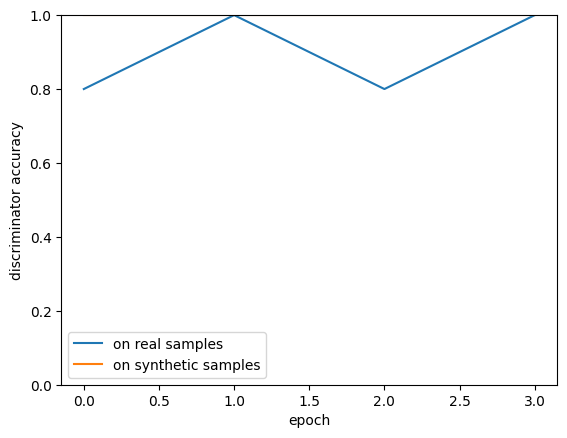

*** scaler is none


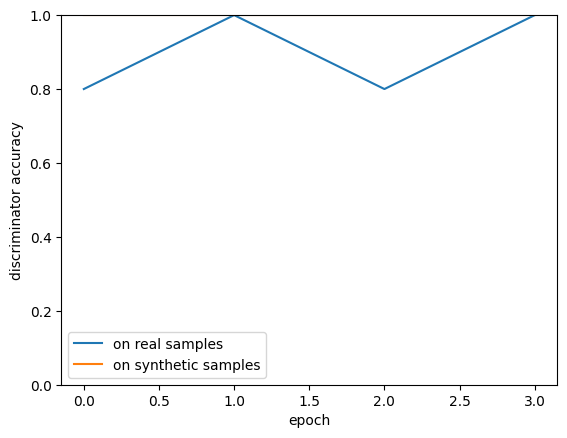

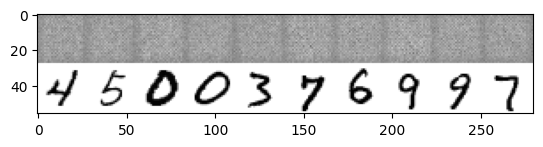

>>> saving intermediate model


INFO:tensorflow:Assets written to: venvtest_temp_generator_epoch_3_1.00_1.00.model/assets


INFO:tensorflow:Assets written to: venvtest_temp_generator_epoch_3_1.00_1.00.model/assets


INFO:tensorflow:Assets written to: venvtest_temp_discriminator_epoch_3_1.00_1.00.model/assets


INFO:tensorflow:Assets written to: venvtest_temp_discriminator_epoch_3_1.00_1.00.model/assets


INFO:tensorflow:Assets written to: venvtest_temp_gan_epoch_3_1.00_1.00.model/assets


INFO:tensorflow:Assets written to: venvtest_temp_gan_epoch_3_1.00_1.00.model/assets


train time: 30.02885413169861


In [9]:
start = time.time()
mygan.train(scaleddata, 
            scaler=scaler, 
            n_epochs=4, 
            n_batch=256,  
            n_eval=1,
            progress_bar=True,
            train_discriminator=True, 
            file_prefix='venvtest')
stop = time.time()
print('train time: {}'.format(stop - start))

## exploring latent space

In [ ]:
import keras
gen_filename = ''
gen = keras.models.load_model(gen_filename)

n=3
min_k = 10
min_j = 10

disparray = np.zeros((28*n,28*n))
for k in range(n): 
    for j in range(n):
        latent_scan_k = -min_k + 2*min_k*k/n
        latent_scan_j = -min_j + 2*min_j*j/n
        latents = np.zeros((1, 100))
        latents[0,20] = latent_scan_k
        latents[0,16] = latent_scan_j
        preds = np.squeeze(gen.predict(latents, verbose=False))

        disparray[28*j:28*(j+1), 28*k:28*(k+1)] = preds

fig, axs = plt.subplots(1,1)
axs.imshow(disparray, cmap='gray_r')

plt.show()